In [1]:
import os

In [2]:
for i in ['data', 'model', 'img', 'result']:
    if not os.path.exists(i):
        os.makedirs(i)

# Download data

In [3]:
if not os.path.exists(os.path.join('data', 'train.csv')):
    !kaggle competitions download -c playground-series-s5e3
    !unzip playground-series-s5e3.zip -d data
    !rm playground-series-s5e3.zip
    !kaggle datasets download subho117/rainfall-prediction-using-machine-learning
    !unzip rainfall-prediction-using-machine-learning.zip -d data
    !rm rainfall-prediction-using-machine-learning.zip

  0%|                                               | 0.00/59.0k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 59.0k/59.0k [00:00<00:00, 1.43MB/s]
Archive:  playground-series-s5e3.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          
Dataset URL: https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning
License(s): MIT
  0%|                                               | 0.00/6.55k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 6.55k/6.55k [00:00<00:00, 893kB/s]
Archive:  rainfall-prediction-using-machine-learning.zip
  inflating: data/Rainfall.csv       


In [28]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn
import scipy

from sklearn.pipeline import make_pipeline
import sgpp, dproc, sgutil

for i in [pl, pd, np, mpl, sns, lgb, sklearn, scipy]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

polars 1.12.0
pandas 2.2.2
numpy 1.26.4
matplotlib 3.8.4
seaborn 0.13.2
lightgbm 4.3.0
sklearn 1.4.2
scipy 1.13.0


# Descriptive Analysis

In [5]:
p1 = make_pipeline(
    sgpp.PolarsProcessor(predefined_types = {'id': pl.Int64}),
    sgpp.PandasCoverter(index_col = 'id')
)
df_train = p1.fit_transform(['data/train.csv'])

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int16  
 1   pressure       2190 non-null   float32
 2   maxtemp        2190 non-null   float32
 3   temparature    2190 non-null   float32
 4   mintemp        2190 non-null   float32
 5   dewpoint       2190 non-null   float32
 6   humidity       2190 non-null   float32
 7   cloud          2190 non-null   float32
 8   sunshine       2190 non-null   float32
 9   winddirection  2190 non-null   float32
 10  windspeed      2190 non-null   float32
 11  rainfall       2190 non-null   int8   
dtypes: float32(10), int16(1), int8(1)
memory usage: 109.1 KB


In [7]:
target = 'rainfall'
X = [
    'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
    'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed'
]
sc = sgutil.SGCache('img', 'result')

In [8]:
pd.concat([
    df_train[X].describe(),
    df_train[X].apply(lambda x: x.nunique()).rename('nunique').to_frame().T
])

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602051,26.365799,23.953056,22.170092,20.454567,82.036530,75.721916,3.744429,104.863152,21.804703
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800653,18.026497,3.626327,80.002411,9.898659
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000
25%,89.000000,1008.599976,21.299999,19.299999,17.700001,16.799999,77.000000,69.000000,0.400000,40.000000,14.125000
50%,178.500000,1013.000000,27.799999,25.500000,23.849999,22.150001,82.000000,83.000000,2.400000,70.000000,20.500000
75%,270.000000,1017.774994,31.200001,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000
max,365.000000,1034.599976,36.000000,31.500000,29.799999,26.700001,98.000000,100.000000,12.100000,300.000000,59.500000
nunique,365.000000,236.000000,219.000000,198.000000,199.000000,218.000000,49.000000,78.000000,120.000000,35.000000,223.000000


In [9]:
df_test = p1.transform(['data/test.csv'])

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2190 to 2919
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            730 non-null    int16  
 1   pressure       730 non-null    float32
 2   maxtemp        730 non-null    float32
 3   temparature    730 non-null    float32
 4   mintemp        730 non-null    float32
 5   dewpoint       730 non-null    float32
 6   humidity       730 non-null    float32
 7   cloud          730 non-null    float32
 8   sunshine       730 non-null    float32
 9   winddirection  729 non-null    float32
 10  windspeed      730 non-null    float32
dtypes: float32(10), int16(1)
memory usage: 35.6 KB


In [11]:
pd.concat([
    df_test[X].describe(),
    df_test[X].apply(lambda x: x.nunique()).rename('nunique').to_frame().T
])

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000
mean,183.000000,1013.503052,26.372467,23.963287,22.110273,20.460138,82.669861,76.360275,3.664384,103.923180,22.484247
std,105.438271,5.505871,5.672521,5.278099,5.170743,5.391169,7.818714,17.934122,3.639272,81.695457,9.954779
min,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000
25%,92.000000,1008.725006,21.600000,19.824999,17.824999,16.799999,77.250000,69.000000,0.325000,40.000000,14.500000
50%,183.000000,1012.700012,27.799999,25.650001,23.900000,22.299999,82.000000,83.000000,2.200000,70.000000,21.299999
75%,274.000000,1017.599976,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000
max,365.000000,1032.199951,35.799999,31.799999,29.100000,26.700001,98.000000,100.000000,11.800000,300.000000,59.500000
nunique,365.000000,185.000000,182.000000,175.000000,171.000000,172.000000,42.000000,69.000000,110.000000,29.000000,205.000000


In [12]:
df_org = make_pipeline(
    sgpp.PolarsProcessor(predefined_types = {'id': pl.Int64, 'day': pl.Int16, 'rainfall': pl.String}),
    sgpp.ExprProcessor({
        'rainfall': pl.col('rainfall').replace({'yes': 1, 'no': 0}).cast(pl.Int8)
    }),
    sgpp.PandasCoverter(index_col = 'id'), 
).fit_transform(['data/Rainfall.csv']).rename(
    columns = lambda x: x.strip()
)

In [13]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            366 non-null    int16  
 1   pressure       366 non-null    float32
 2   maxtemp        366 non-null    float32
 3   temparature    366 non-null    float32
 4   mintemp        366 non-null    float32
 5   dewpoint       366 non-null    float32
 6   humidity       366 non-null    int8   
 7   cloud          366 non-null    int8   
 8   rainfall       366 non-null    int8   
 9   sunshine       366 non-null    float32
 10  winddirection  365 non-null    float32
 11  windspeed      365 non-null    float32
dtypes: float32(8), int16(1), int8(3)
memory usage: 13.4 KB


In [14]:
pd.concat([
    df_org[X].describe(),
    df_org[X].apply(lambda x: x.nunique()).rename('nunique').to_frame().T
])

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,365.000000,365.000000
mean,15.756831,1013.742554,26.191257,23.747269,21.894535,19.989071,80.177596,71.128415,4.419399,101.506851,21.536985
std,8.823592,6.414776,5.978343,5.632813,5.594152,5.997021,10.062470,21.798012,3.934398,81.723724,10.069712
min,1.000000,998.500000,7.100000,4.900000,3.100000,-0.400000,36.000000,0.000000,0.000000,10.000000,4.400000
25%,8.000000,1008.500000,21.200001,18.824999,17.125000,16.125000,75.000000,58.000000,0.500000,40.000000,13.700000
50%,16.000000,1013.000000,27.750000,25.450000,23.700001,21.950000,80.500000,80.000000,3.500000,70.000000,20.500000
75%,23.000000,1018.099976,31.200001,28.600000,26.575000,25.000000,87.000000,88.000000,8.200000,190.000000,27.900000
max,31.000000,1034.599976,36.299999,32.400002,30.000000,26.700001,98.000000,100.000000,12.100000,350.000000,59.500000
nunique,31.000000,188.000000,174.000000,158.000000,157.000000,158.000000,49.000000,79.000000,104.000000,31.000000,223.000000


In [15]:
df_org.loc[df_org[X].isna().any(axis=1)]

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
160,9,1005.700012,31.700001,28.200001,26.6,25.700001,86,79,1,6.5,NaN,NaN


# Train / Test / Org Difference

## Train vs Test 

In [16]:
from sklearn.model_selection import cross_validate, StratifiedKFold
import lightgbm as lgb

In [17]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_train[X].assign(is_train = True),
    df_test[X].assign(is_train = False)
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.02565742, 0.01521301, 0.01457572, 0.01463652, 0.01535273]),
 'score_time': array([0.00275469, 0.00188851, 0.00150609, 0.00147581, 0.00149822]),
 'test_score': array([0.45865391, 0.49407331, 0.48434666, 0.46880278, 0.49080503]),
 'train_score': array([0.96311554, 0.96476092, 0.96260145, 0.96829651, 0.97169282])}

Train과 Test Set의 구분이 어렵습니다.

## Train vs Org

In [18]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_train[X + [target]].assign(is_train = True),
    df_org[X + [target]].assign(is_train = False)
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X + [target]], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.01712942, 0.01560092, 0.01643205, 0.01423764, 0.01458025]),
 'score_time': array([0.00195193, 0.0014782 , 0.00151873, 0.001477  , 0.00152445]),
 'test_score': array([0.9922251 , 0.98570714, 0.9847376 , 0.9811722 , 0.99218115]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [19]:
clf_lgb = lgb.LGBMClassifier(verbose = 0, num_leaves = 15).fit(df[X + [target]], df['is_train'])

In [20]:
pd.Series(
    clf_lgb.feature_importances_, index = X + [target]
).sort_values(ascending = False).iloc[:5]

day            278
windspeed      201
dewpoint       159
maxtemp        129
temparature    124
dtype: int32

In [21]:
df_train['day'].value_counts()

day
91     7
144    7
267    7
140    7
111    7
      ..
157    5
286    5
38     5
336    5
365    5
Name: count, Length: 365, dtype: int64

In [22]:
X_ = [i for i in X + [target] if i != 'day']

cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X_], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.01651859, 0.01686621, 0.01626062, 0.01568866, 0.01455927]),
 'score_time': array([0.00175381, 0.00167084, 0.00150681, 0.0015142 , 0.0014677 ]),
 'test_score': array([0.51604344, 0.53480953, 0.57315319, 0.50134484, 0.5511353 ]),
 'train_score': array([0.9829549 , 0.98471664, 0.98433969, 0.9833345 , 0.98481891])}

원본 데이터와 학습 데이터는 구분이 명확히 되지만,
day 속성을 빼면 구분이 어렵습니다.

그리고, 원본 데이터는 day는 일자상의 day이고 Playground는 dayofyear를 나타냅니다.

**TODO**: 데이터가 적습니다. 원본 데이터의 day를 Playground 셋에 맞추어 사용할 수 있을지 살펴봅니다.

## Target Distribution

In [23]:
df_train[target].value_counts(normalize=True)

rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64

In [24]:
df_org[target].value_counts(normalize=True)

rainfall
1    0.680328
0    0.319672
Name: proportion, dtype: float64

## Features

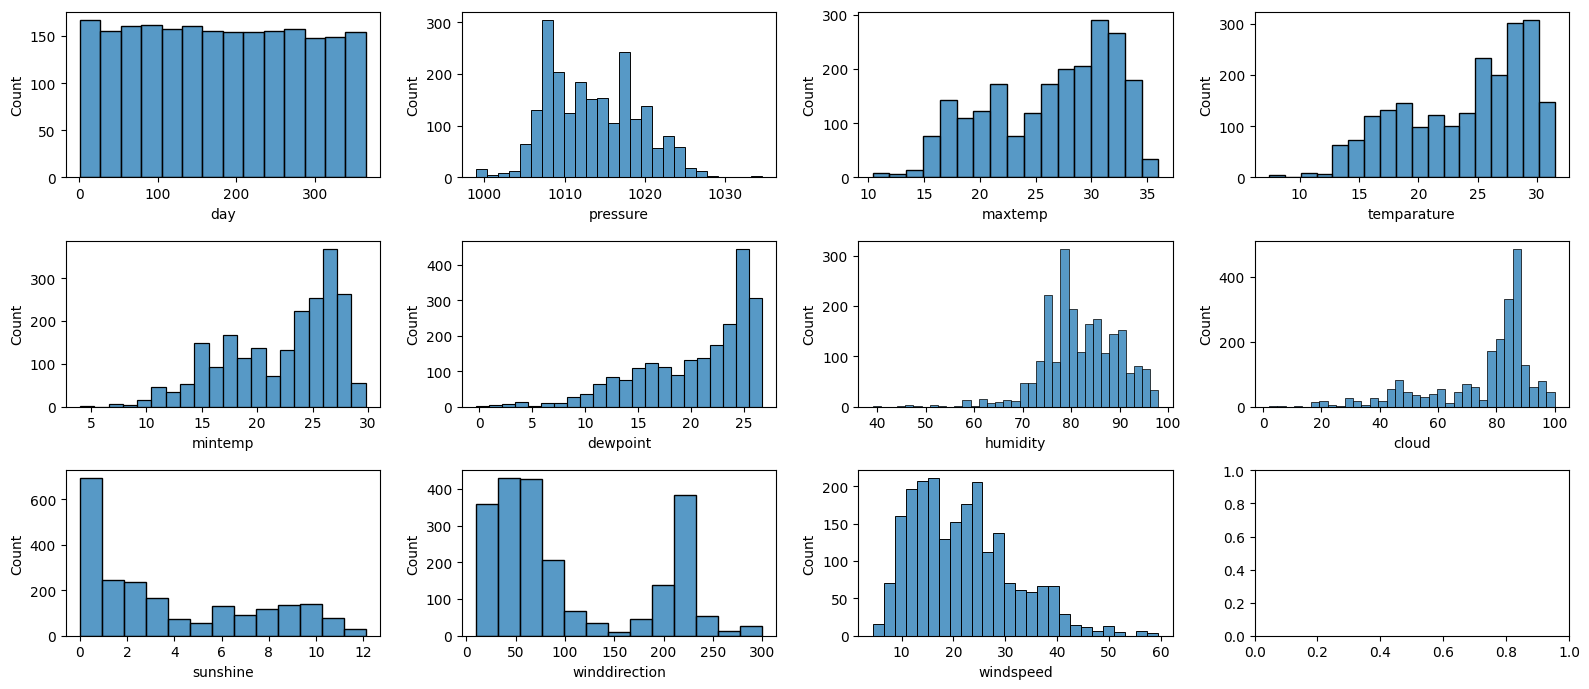

In [32]:
sc.cache_fig(
    'dist_features', lambda x: [sns.histplot(df_train, x=i, ax=ax) for i, ax in zip(X, x)] , 3, 4, (16, 7), redraw = False
)

# Exploratory Data Analysis

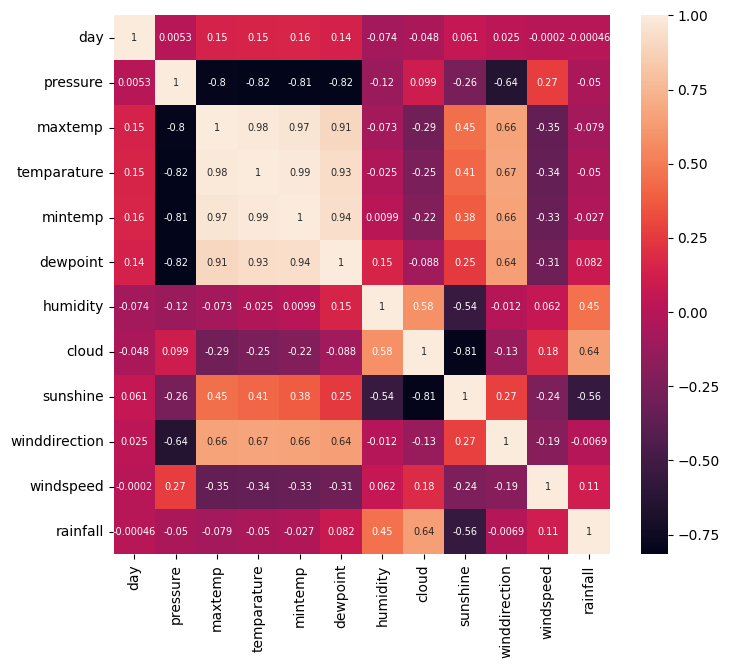

In [31]:
plt.figure(figsize = (8, 7))
sns.heatmap(
    df_train[X + [target]].corr(),
    annot = True, annot_kws = {'size': 7}
)
plt.show()

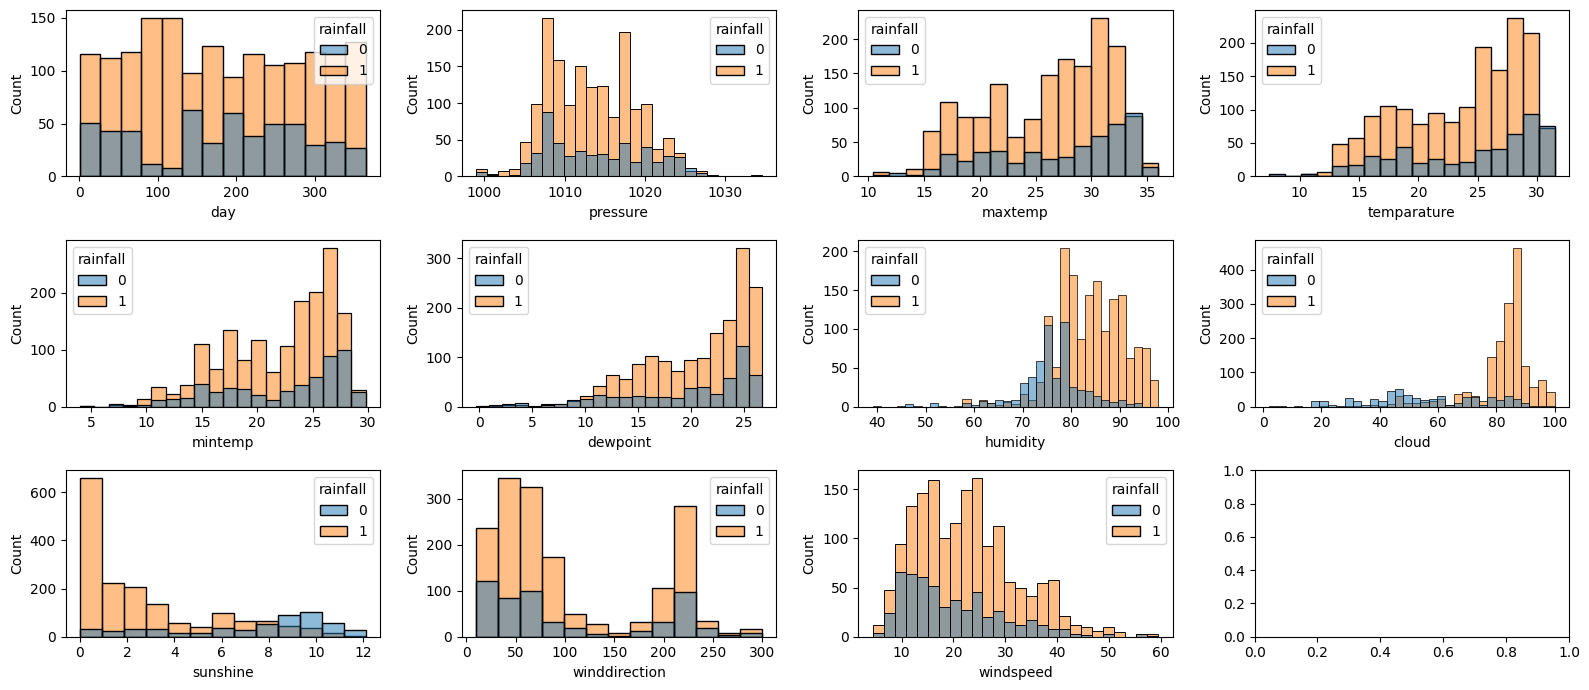

In [33]:
sc.cache_fig(
    'dist_features_tgt', lambda x: [sns.histplot(df_train, x=i, ax=ax, hue=target) for i, ax in zip(X, x)] , 3, 4, (16, 7), redraw = False
)

## Relation with day

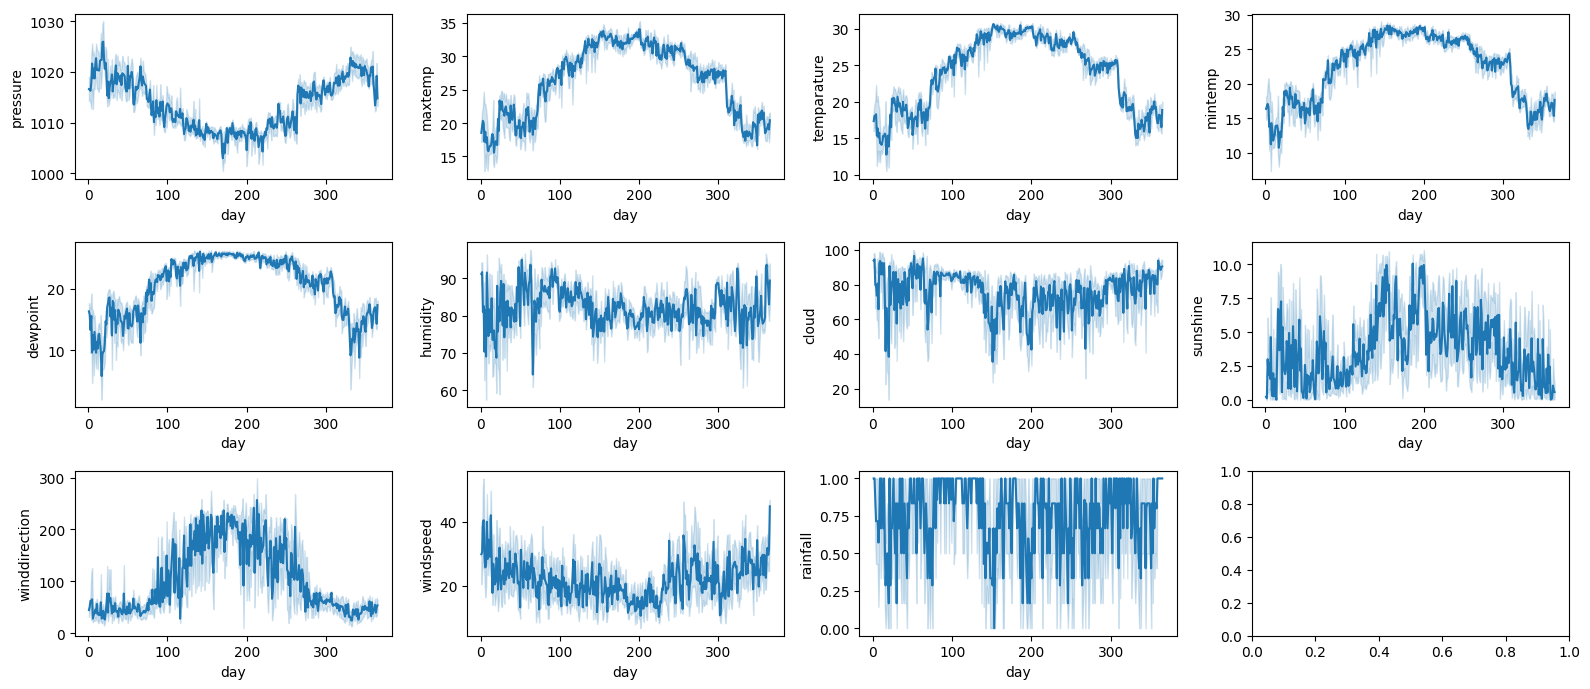

In [37]:
X_ = [i for i in X if i != 'day'] + [target]
sc.cache_fig(
    'lineplot_day', lambda x: [sns.lineplot(df_train, x='day', y= i, ax=ax) for i, ax in zip(X_, x)] , 3, 4, (16, 7), redraw = False
)

In [39]:
df_train['day'].value_counts().value_counts()

count
6    297
7     34
5     34
Name: count, dtype: int64

In [40]:
df_test['day'].value_counts().value_counts()

count
2    365
Name: count, dtype: int64

In [45]:
df_train['day'].value_counts().pipe(
    lambda x: x.loc[x == 5]
).sort_index().pipe(
    lambda x: pd.concat([x, x.index.to_series().pipe(lambda x: x - x.shift(1)).rename('delta')], axis=1)
)

,count,delta
day,,
38,5,NaN
157,5,119.0
190,5,33.0
196,5,6.0
218,5,22.0
224,5,6.0
252,5,28.0
258,5,6.0
273,5,15.0


In [44]:
df_train['day'].value_counts().pipe(
    lambda x: x.loc[x == 7]
).sort_index().pipe(
    lambda x: pd.concat([x, x.index.to_series().pipe(lambda x: x - x.shift(1)).rename('delta')], axis=1)
)

,count,delta
day,,
3,7,NaN
4,7,1.0
5,7,1.0
6,7,1.0
7,7,1.0
8,7,1.0
9,7,1.0
15,7,6.0
16,7,1.0


학습데이터의 day의 빈도가 5인것이 34개 7인것이 34개 동수가 존재하며 나머지는 6개라는 점에서 day에는 노이즈가 있을 가능성이 높습니다.

[Binary Prediction with a Rainfall Dataset](https://www.kaggle.com/competitions/playground-series-s5e3/discussion/565634) 에서 이와 관련된 현상이 나와 있습니다.

In [50]:
df_train['expected_day'] = (df_train.index % 365) + 1
df_train.query('expected_day != day')

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,expected_day
id,,,,,,,,,,,,,
1037,3,1015.200012,25.000000,23.900000,23.600000,19.900000,76.0,61.0,8.8,90.0,14.100000,0,308
1132,265,1020.599976,18.400000,17.100000,16.900000,15.000000,75.0,86.0,0.0,40.0,24.900000,1,38
1210,80,1011.500000,29.799999,26.799999,25.100000,23.200001,87.0,81.0,2.5,20.0,12.700000,1,116
1251,236,1005.000000,35.299999,31.000000,26.400000,26.400000,74.0,49.0,10.8,230.0,28.600000,1,157
1284,4,1007.900024,33.000000,30.100000,27.799999,25.100000,78.0,67.0,5.7,220.0,12.500000,1,190
1290,16,1008.400024,32.299999,29.000000,26.500000,24.400000,79.0,40.0,11.2,220.0,12.400000,0,196
1312,5,1005.700012,31.700001,28.500000,27.299999,24.299999,76.0,49.0,7.2,240.0,15.100000,1,218
1318,6,1002.500000,32.000000,28.900000,26.400000,24.900000,84.0,73.0,8.4,20.0,9.500000,1,224
1346,151,1008.400024,32.799999,29.400000,27.000000,24.299999,74.0,27.0,10.6,220.0,12.400000,0,252


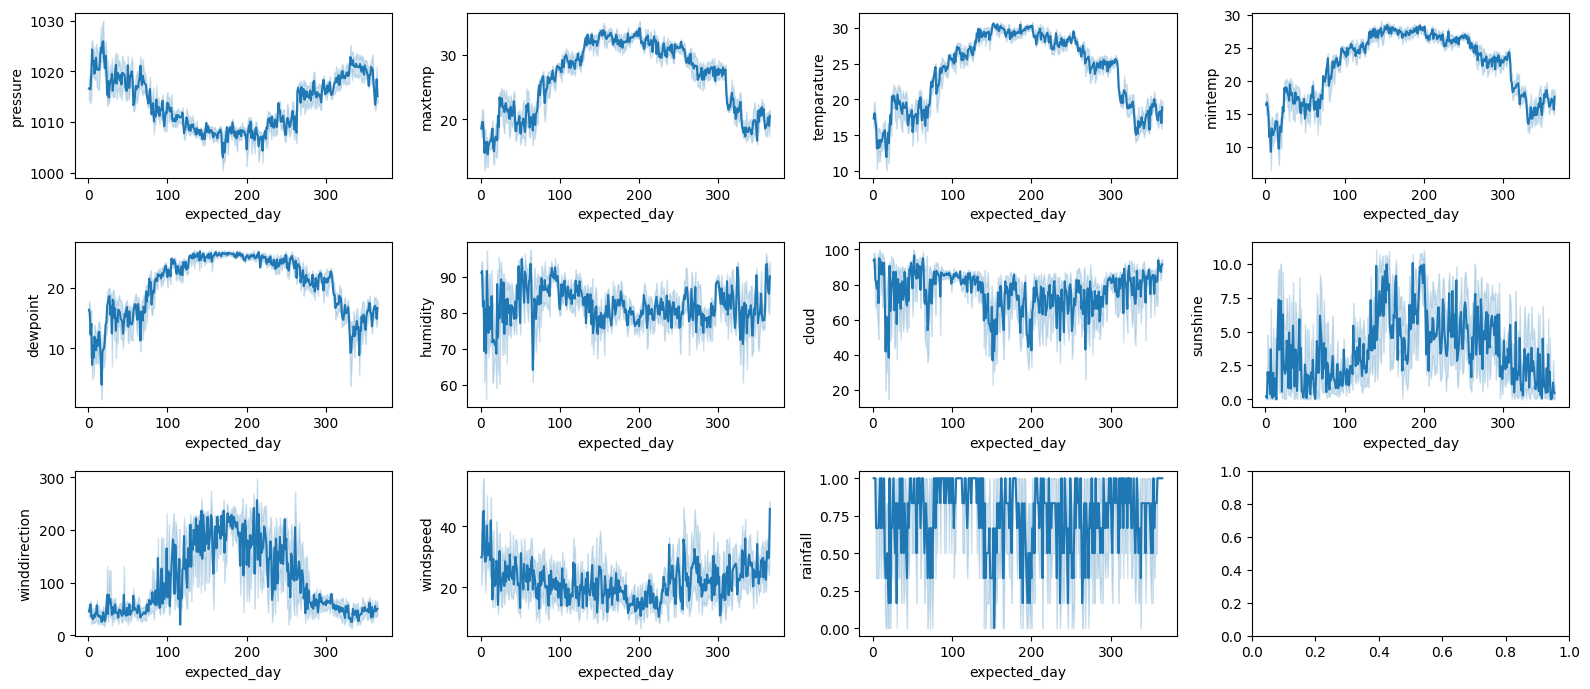

In [61]:
X_ = [i for i in X if i != 'day'] + [target]
sc.cache_fig(
    'lineplot_expected_day', lambda x: [sns.lineplot(df_train, x='expected_day', y= i, ax=ax) for i, ax in zip(X_, x)] , 3, 4, (16, 7), redraw = False
)

id가 시간 순서에 따르는 것이 가능성이 높아 보입니다. 

**TODO** day와 expected_day 사용했을 때와의 성능차이 비교

원본 데이터도 시간순서대로 배치가 되었는지 살펴봅니다.

In [58]:
(df_org['day'] - df_org['day'].shift()).value_counts()

day
 1.0     354
-30.0      6
-29.0      4
-28.0      1
Name: count, dtype: int64

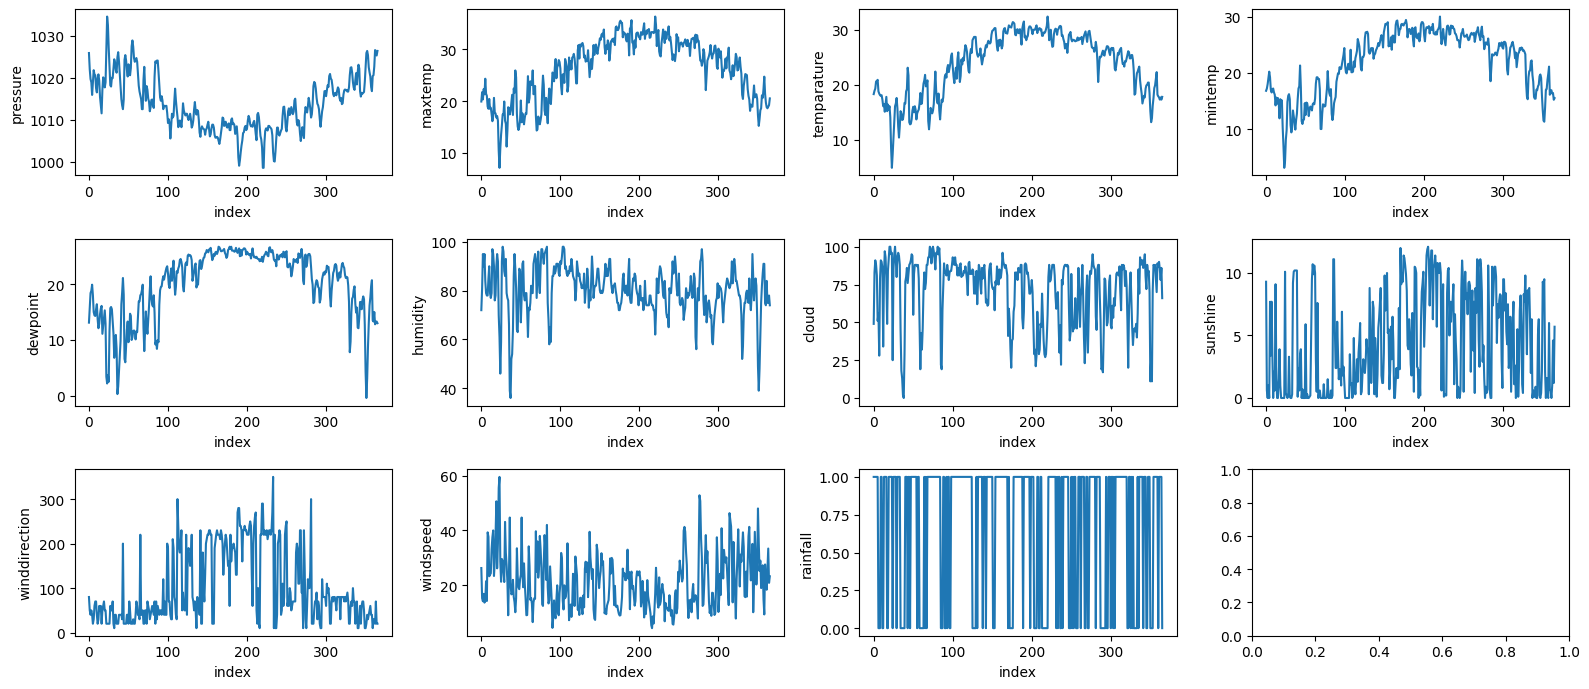

In [60]:
X_ = [i for i in X if i != 'day'] + [target]
sc.cache_fig(
    'lineplot_day_org', lambda x: [sns.lineplot(df_org.reset_index(), x='index', y= i, ax=ax) for i, ax in zip(X_, x)] , 3, 4, (16, 7), redraw = False
)

## Train과 Org 재비교

In [62]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_train[X + [target]].assign(is_train = True),
    df_org[X + [target]].assign(is_train = False, day = lambda x: x.index + 1).dropna().query('day < 366')
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X + [target]], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.02669191, 0.01603842, 0.0156889 , 0.01472211, 0.01473737]),
 'score_time': array([0.00378251, 0.00211096, 0.00163245, 0.00150776, 0.00158   ]),
 'test_score': array([0.77459811, 0.73515982, 0.78304247, 0.80724964, 0.77356038]),
 'train_score': array([0.99573977, 0.99641843, 0.9971167 , 0.99574173, 0.9965773 ])}

org의 day를 일자순서로 정렬 데이터로 가정을 하고 day를 365일 단위로 변환을 했을 때에도 어느 정도 kaggle 데이터와 원본데이터에 차이를 보입니다.

In [64]:
skf = StratifiedKFold(5, random_state = 123, shuffle=True)
df = pd.concat([
    df_test[X].assign(is_train = True),
    df_org[X].assign(is_train = False, day = lambda x: x.index + 1).dropna().query('day < 366')
], axis = 0)
cross_validate(lgb.LGBMClassifier(verbose = 0, num_leaves = 15), df[X], df['is_train'], scoring = 'roc_auc', cv = skf, return_train_score = True)

{'fit_time': array([0.0150404 , 0.01526523, 0.01175809, 0.01131964, 0.01111913]),
 'score_time': array([0.00264812, 0.00182343, 0.00162196, 0.0013752 , 0.00133681]),
 'test_score': array([0.73662976, 0.76599737, 0.79968099, 0.69797335, 0.7613204 ]),
 'train_score': array([0.99921739, 0.99792285, 0.99804053, 0.99923504, 0.99907933])}

test하고도 차이가 train 와 차이가 비슷한 정도로 보입니다.